Running Technical Momentum strategies (SMA, RSI, refer to KNN bot for MACD)

First we will run a RSI Strategy on Tesla. We extract data from yahoo finance and compute the RSI at each EOD and setup Long and Short tresholds.
Then we will do a SMA strategy on a NVIDIA. We extract the data from yahoo finance and compute and compare our SMA50 and SMA200 lines. 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Downloading historical stock data for Tesla
ticker = 'TSLA'
data = yf.download(ticker, start='2022-01-01', end='2025-01-01')
# Displaying the first few rows of the dataset
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2022-01-03  399.926666  400.356659  378.679993  382.583344  103931400
2022-01-04  383.196655  402.666656  374.350006  396.516663  100248300
2022-01-05  362.706665  390.113342  360.336670  382.216675   80119800
2022-01-06  354.899994  362.666656  340.166656  359.000000   90336600
2022-01-07  342.320007  360.309998  336.666656  360.123322   84164700


Now we compute the Relative Strenght Index, ranging from 0 to 100, considering values above 60 as a Long Signal and values under 40 as a Short signal

In [3]:
def compute_rsi(data, window=14):
 #We get the difference between the closing price and yesterday's closing price
 delta = data['Close'].diff()
 #We compute the means of loosses and gains, using the .where function to isolate them
 gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
 loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
 
 rs = gain / loss
 rsi = 100 - (100 / (1 + rs))
 return rsi


In [4]:
#Using .loc here, to apply the values to our current pandas df and not a copy
# Compute the RSI and create long/short signals
data.loc[:, 'RSI']  = compute_rsi(data)
#Reset our signal column to 0 as we will use RSI as signal
data.loc[:, 'Signal'] = 0
#We add again the ticker as index of our pandas df
data.loc[data['RSI'] < 40, 'Signal'] = -1 # Short when RSI < 40
data.loc[data['RSI'] > 60, 'Signal'] = 1 # Long when RSI > 60
# Display data with RSI and signals
print(data[['Close', 'RSI', 'Signal']].tail())


Price            Close        RSI Signal
Ticker            TSLA                  
Date                                    
2024-12-24  462.279999  72.174769      1
2024-12-26  454.130005  68.250827      1
2024-12-27  431.660004  59.044415      0
2024-12-30  417.410004  55.561821      0
2024-12-31  403.839996  50.568478      0


Now we backtest the strategy and visualize it

In [5]:
#We get percentage changes at each date
data['Returns'] = data['Close'].pct_change()
#Get our returns depending if we Buy or Sell
# We use shift so that our Buy or Sell strategy is applied on the next day and not the current one
data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']
#.cumprod is used to compute cumulative returns 
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns'].fillna(0)).cumprod()


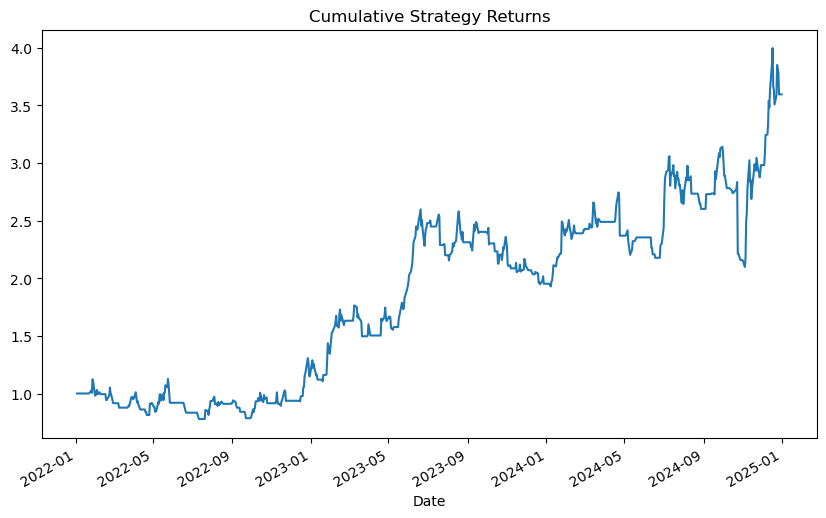

In [6]:
# Plot cumulative returns
data['Cumulative_Strategy_Returns'].plot(figsize=(10, 6),
title='Cumulative Strategy Returns')
plt.show()


Now will run a Simple Moving Average technique on the Nvidia stock

Now we get the data from yahoo finance, which will be used to compute the SMA and get our Long and Short signals

In [7]:
# Downloading historical stock data for Tesla
ticker = 'NVDA'
data = yf.download(ticker, start='2022-01-01', end='2025-01-01')
# Displaying the first few rows of the dataset
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2022-01-03  30.068222  30.657188  29.732810  29.762758  391547000
2022-01-04  29.238678  30.414613  28.299327  30.223948  527154000
2022-01-05  27.555630  29.364455  27.484755  28.898272  498064000
2022-01-06  28.128630  28.388174  27.017581  27.591572  454186000
2022-01-07  27.199257  28.372199  27.009589  28.091691  409939000


Creating the SMA Strategy based on YF data

In [8]:
# Calculate 50-day and 200-day moving averages
#There is a double indexing in the data from Yahoo Finance, so we need to add the relevant ticker in the SMA computation
data['SMA_50'] = data[('Close', ticker)].rolling(window=50).mean()
data['SMA_200'] = data[('Close', ticker)].rolling(window=200).mean()

# Create buy/sell signals
data['Signal'] = 0
#We start computing / using our signal at the 200th row, when we can compute both the 50SMA and 200SMA
#np.where gives either 1 if the condition is true or 0 if not true
#we need tu use .iloc to allow for integers to reference the right row
#We use get_loc to ensure that we update Signal on the correct / same row
data.iloc[200:, data.columns.get_loc('Signal')] = np.where(data['SMA_50'][200:] > data['SMA_200'][200:], 1, -1)

# Display the rows with signals
print(data[['Close', 'SMA_50', 'SMA_200', 'Signal']].iloc[200:])


Price            Close      SMA_50     SMA_200 Signal
Ticker            NVDA                               
Date                                                 
2022-10-19   12.038053   14.266652   19.294283     -1
2022-10-20   12.180902   14.148826   19.208994     -1
2022-10-21   12.452606   14.039530   19.133479     -1
2022-10-24   12.585465   13.917572   19.055763     -1
2022-10-25   13.246756   13.802389   18.986001     -1
...                ...         ...         ...    ...
2024-12-24  140.207108  139.741147  116.887092      1
2024-12-26  139.917130  139.907913  117.127264      1
2024-12-27  136.997391  139.933897  117.357960      1
2024-12-30  137.477356  139.945285  117.605771      1
2024-12-31  134.277649  139.871282  117.838119      1

[553 rows x 4 columns]


Now we backtest the strategy and visualize it

In [9]:
#We get percentage changes at each date
data['Returns'] = data['Close'].pct_change()
#Get our returns depending if we are Long or Short
# We use shift so that our Long or Short strategy is applied on the next day and not the current one
data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']
#.cumprod is used to compute cumulative returns 
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns'].fillna(0)).cumprod()


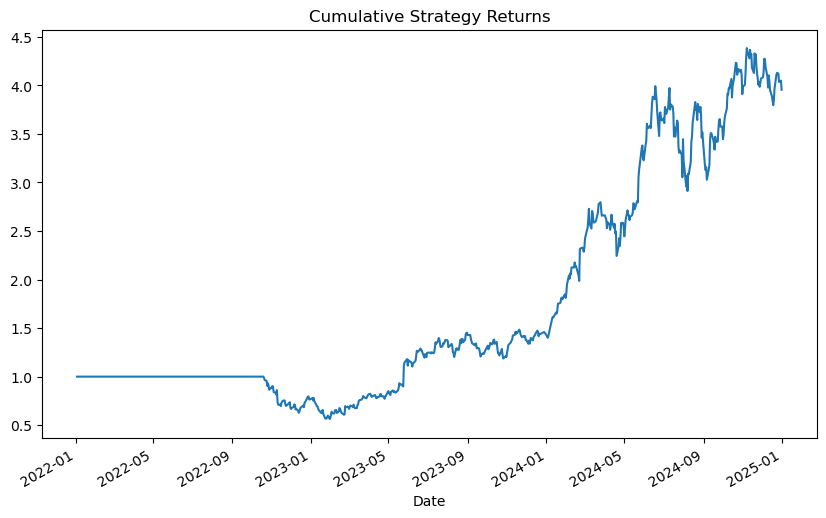

In [10]:
# Plot cumulative returns
data['Cumulative_Strategy_Returns'].plot(figsize=(10, 6),
title='Cumulative Strategy Returns')
plt.show()
